<a href="https://colab.research.google.com/github/ssv273/computer_vision/blob/master/HW_05_TF_object_detection_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

In [0]:
import os
import pathlib


if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Compile protobufs and install the object_detection package

In [0]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [30]:
%%bash 
cd models/research
pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1017522 sha256=0b99c51297b05c8297303c0f8ae754429e74e6a708834c217786e37e83221b85
  Stored in directory: /tmp/pip-ephem-wheel-cache-b36nbw57/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


### Imports

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display

Import the object detection module.

In [0]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

Patches:

In [0]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Model preparation 

## Loader

In [0]:
def load_model(model_name):
  base_url = 'http://download.tensorflow.org/models/object_detection/'
  model_file = model_name + '.tar.gz'
  model_dir = tf.keras.utils.get_file(
    fname=model_name, 
    origin=base_url + model_file,
    untar=True)

  model_dir = pathlib.Path(model_dir)/"saved_model"

  model = tf.saved_model.load(str(model_dir))
  model = model.signatures['serving_default']

  return model

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [0]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

For the sake of simplicity we will test on 2 images:

In [36]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('models/research/object_detection/test_images')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('models/research/object_detection/test_images/image1.jpg'),
 PosixPath('models/research/object_detection/test_images/image2.jpg')]

# Detection

Load an object detection model:

In [37]:
model_name = 'ssd_mobilenet_v1_coco_2017_11_17'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Check the model's input signature, it expects a batch of 3-color images of type uint8: 

In [38]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(None, None, None, 3) dtype=uint8>]


And retuns several outputs:

In [39]:
detection_model.output_dtypes

{'detection_boxes': tf.float32,
 'detection_classes': tf.float32,
 'detection_scores': tf.float32,
 'num_detections': tf.float32}

In [40]:
detection_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

Add a wrapper function to call the model, and cleanup the outputs:

In [0]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Run it on each test image and show the results:

In [0]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

## Instance Segmentation

In [43]:
model_name = "mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28"
masking_model = load_model("mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


The instance segmentation model includes a `detection_masks` output:

In [44]:
masking_model.output_shapes

{'detection_boxes': TensorShape([None, 100, 4]),
 'detection_classes': TensorShape([None, 100]),
 'detection_masks': TensorShape([None, None, None, None]),
 'detection_scores': TensorShape([None, 100]),
 'num_detections': TensorShape([None])}

# Own image

### First image


In [45]:
!wget https://s-kuranty.ru/wp-content/uploads/2019/12/%D0%B6%D0%B8%D0%B2%D0%BE%D1%82%D0%BD%D1%8B%D0%B5-%D0%B8-%D0%BB%D1%8E%D0%B4%D0%B8-1000x675.jpg

--2020-04-23 08:13:55--  https://s-kuranty.ru/wp-content/uploads/2019/12/%D0%B6%D0%B8%D0%B2%D0%BE%D1%82%D0%BD%D1%8B%D0%B5-%D0%B8-%D0%BB%D1%8E%D0%B4%D0%B8-1000x675.jpg
Resolving s-kuranty.ru (s-kuranty.ru)... 193.200.73.128
Connecting to s-kuranty.ru (s-kuranty.ru)|193.200.73.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139662 (136K) [image/jpeg]
Saving to: ‘животные-и-люди-1000x675.jpg.1’

животные-и-люди-100 100%[===================>] 136.39K   226KB/s    in 0.6s    

2020-04-23 08:13:57 (226 KB/s) - ‘животные-и-люди-1000x675.jpg.1’ saved [139662/139662]



In [0]:
my_image_path = '/content/животные-и-люди-1000x675.jpg'

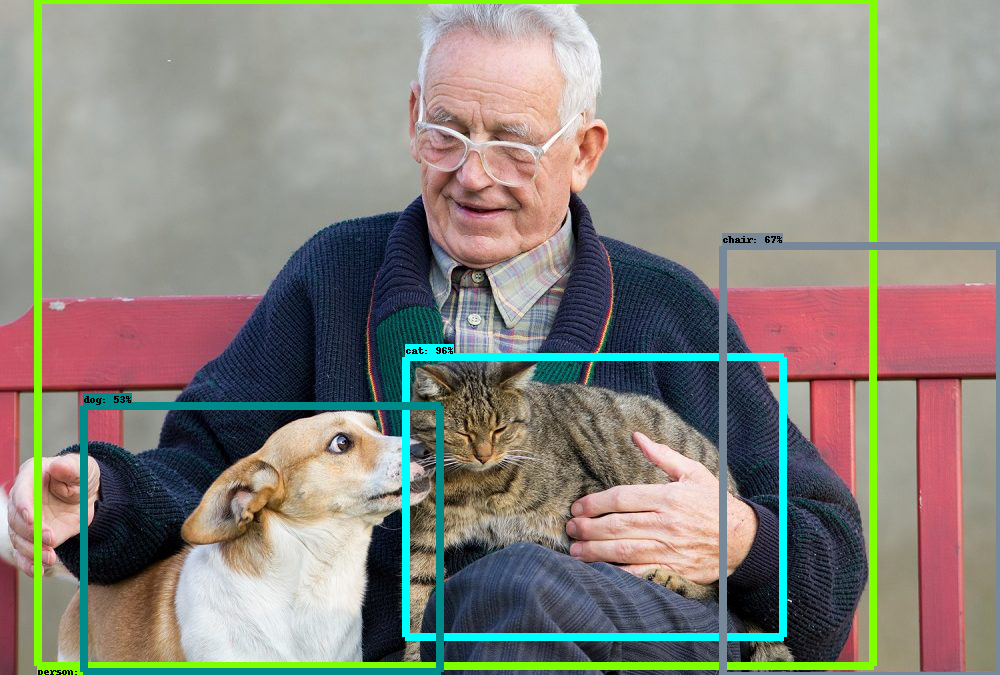

In [47]:
show_inference(detection_model, my_image_path)

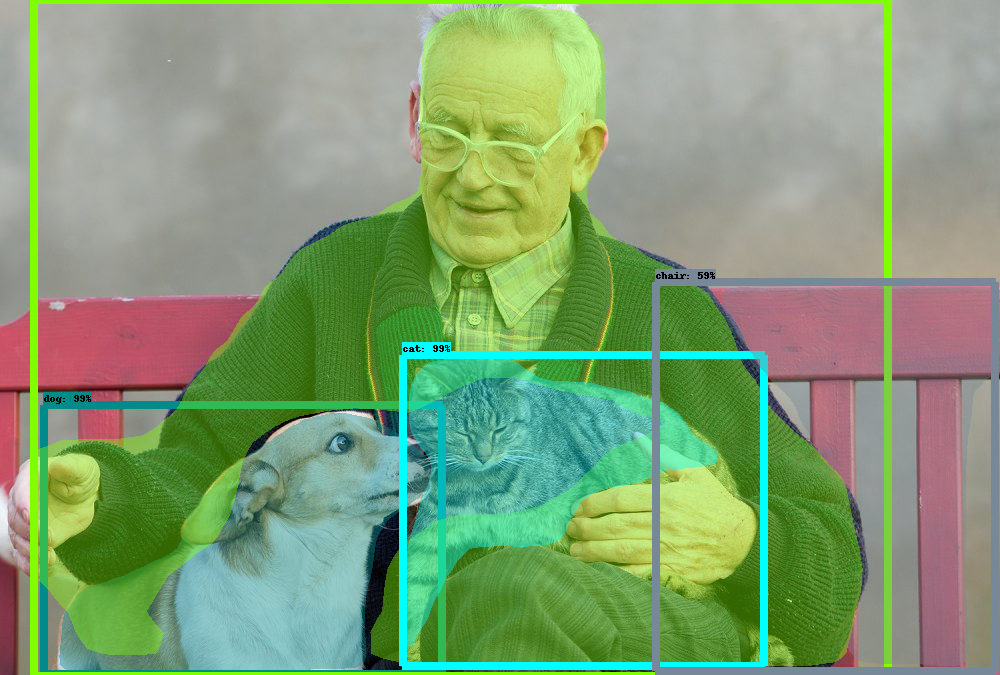

In [48]:
  show_inference(masking_model, my_image_path)

### Second image

In [49]:
!wget https://clockwise.software/img/blog/dealing-with-large-files-in-cordova/header-background.jpg

--2020-04-23 08:14:15--  https://clockwise.software/img/blog/dealing-with-large-files-in-cordova/header-background.jpg
Resolving clockwise.software (clockwise.software)... 45.33.61.46
Connecting to clockwise.software (clockwise.software)|45.33.61.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184714 (180K) [image/jpeg]
Saving to: ‘header-background.jpg.1’

header-background.j 100%[===================>] 180.38K   657KB/s    in 0.3s    

2020-04-23 08:14:16 (657 KB/s) - ‘header-background.jpg.1’ saved [184714/184714]



In [0]:
my_image_path2 = '/content/header-background.jpg'

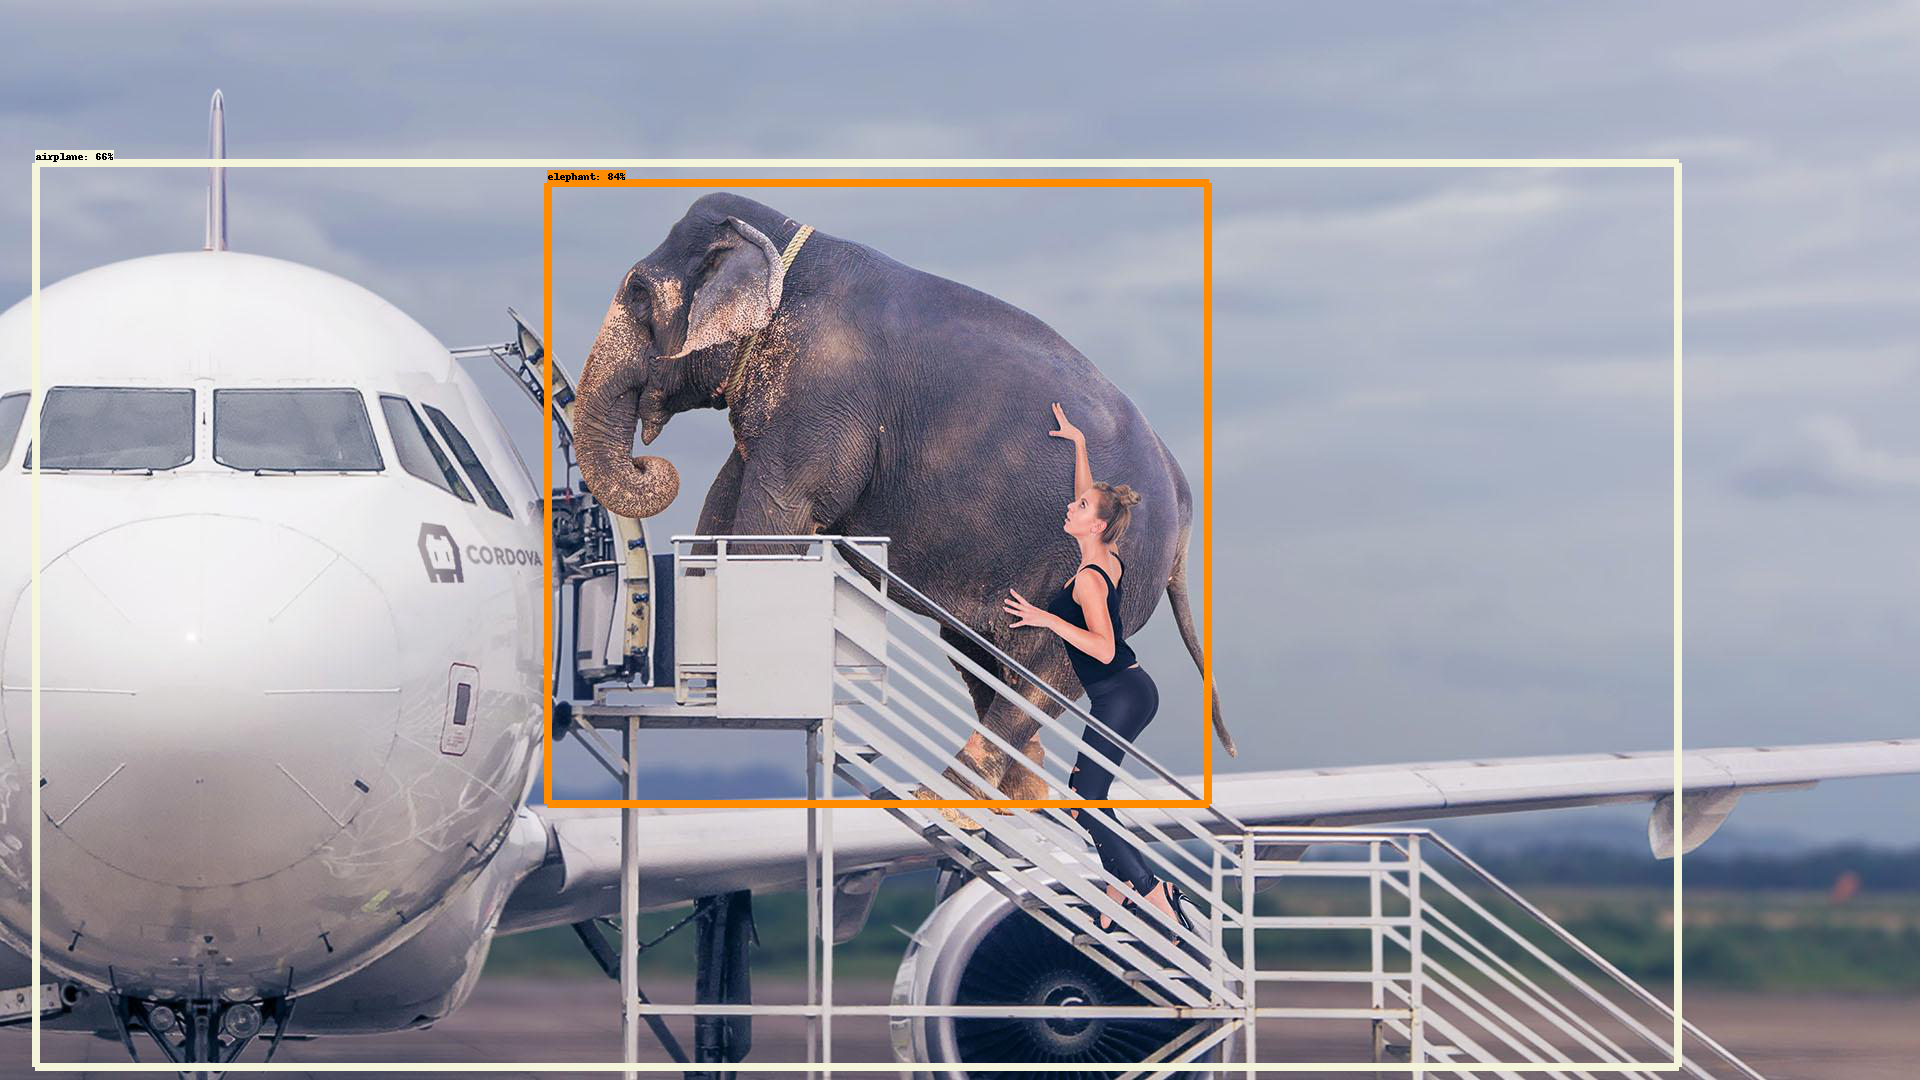

In [51]:
show_inference(detection_model, my_image_path2)

как мы видим - человека не определила модель, однако запустим instance segmentation

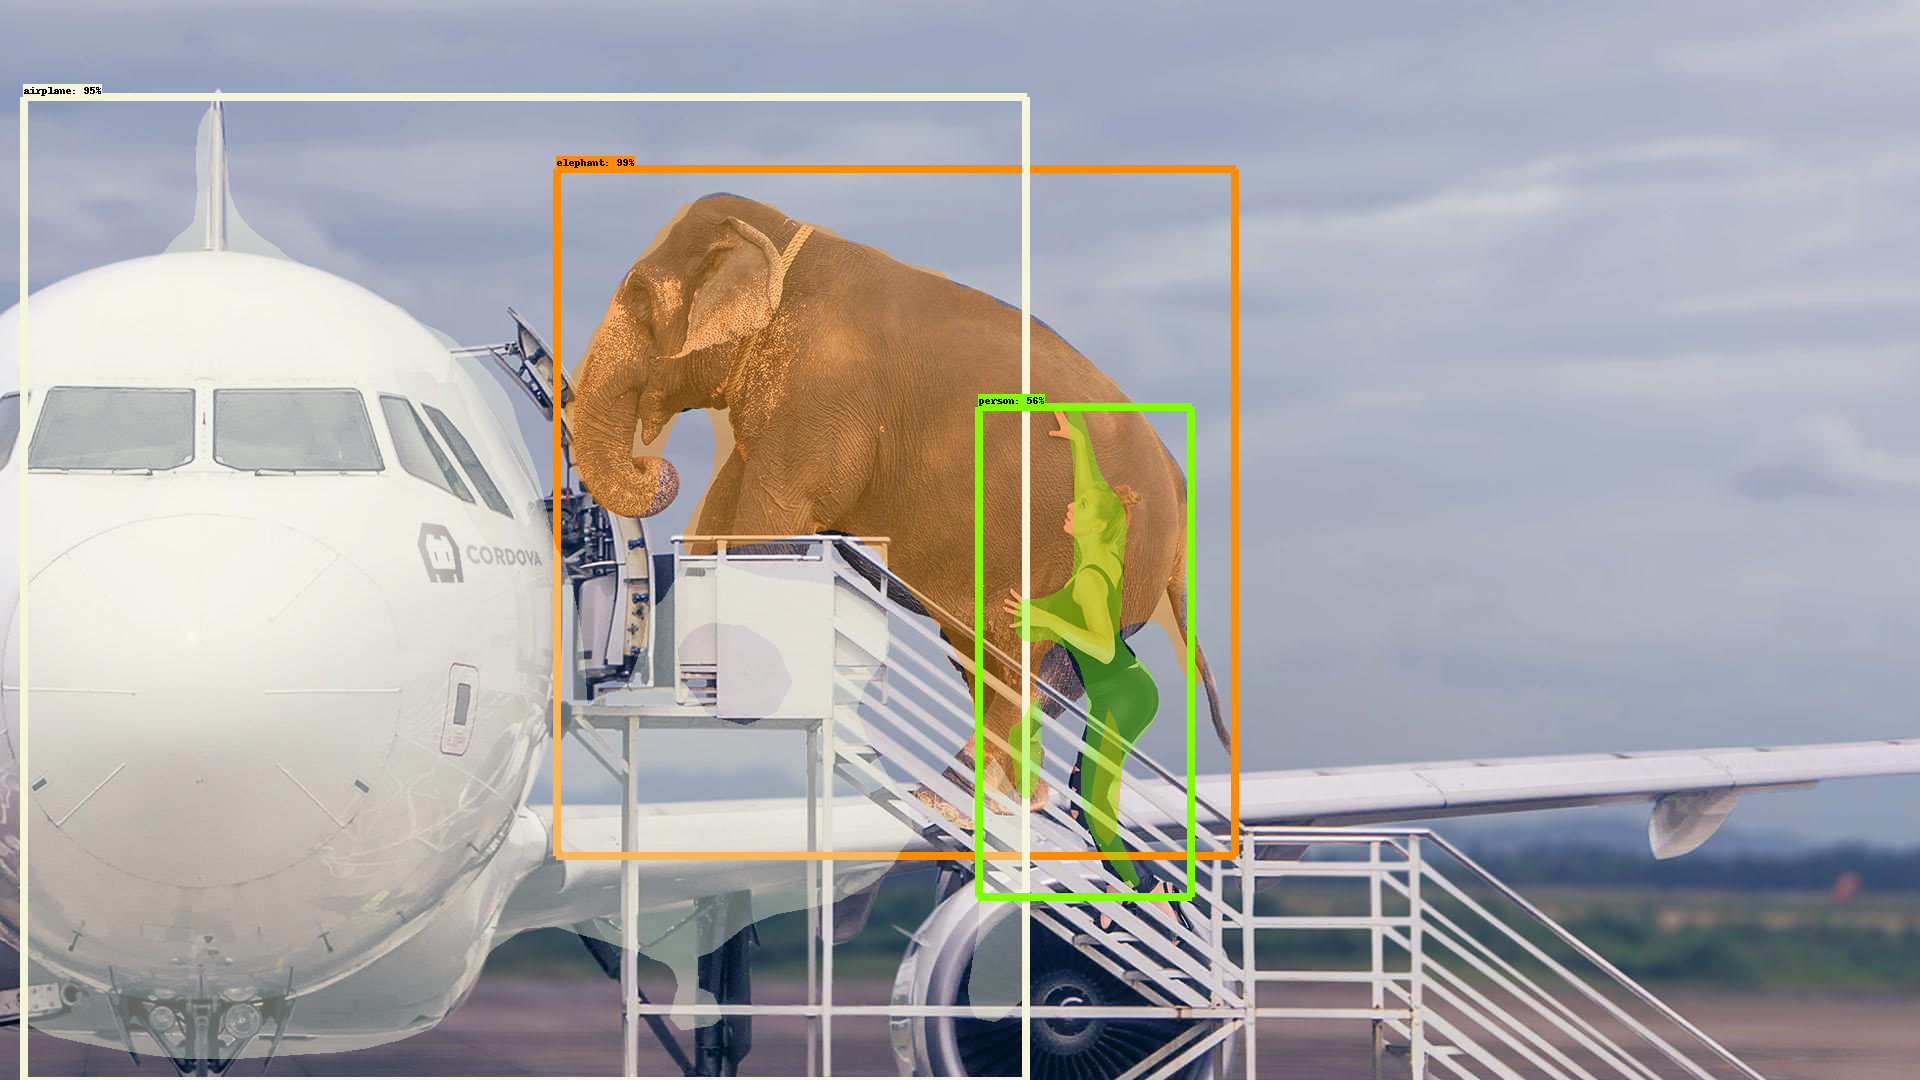

In [52]:
  show_inference(masking_model, my_image_path2)

и вуаля, тут человека модель успешно распознала